In [1]:
import numpy as np
from scipy import ndimage
from scipy.special import expit as sigmoid
from scipy.special import logit as inv_sigmoid

import matplotlib.pyplot as plt

%matplotlib inline

class NeuralNetwork:
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):

        # n of nodes for input, hidden, output layers
        self.inodes = input_nodes
        self.hnodes = hidden_nodes
        self.onodes = output_nodes
        
        # learning rate
        self.lr = learning_rate

        # weights
        self.wih = np.random.normal(0, pow(self.inodes, -0.5), (self.hnodes, self.inodes))
        self.who = np.random.normal(0, pow(self.hnodes, -0.5), (self.onodes, self.hnodes))

    def train(self, input_list, target_list):
        # NOTE: find a way to reutilise self.query() without returning final_output and being able to use the function vars.
        # converts to a transposed 2D array, where it has a single column
        inputs = np.array(input_list, ndmin=2).T
        targets = np.array(target_list, ndmin=2).T

        # calculate signals into hidden layer
        hidden_inputs = np.dot(self.wih, inputs)
        # calculate final signals from hidden layer
        hidden_outputs = sigmoid(hidden_inputs)

        # calculate signals into hidden layer
        final_inputs = np.dot(self.who, hidden_outputs)
        # calculate final signals from hidden layer
        final_outputs = sigmoid(final_inputs)

        output_errors = targets - final_inputs
        hidden_errors = np.dot(self.who.T, output_errors)

        self.who += self.lr * np.dot(output_errors * final_outputs * (1 - final_outputs), np.transpose(hidden_outputs))

        self.wih += self.lr * np.dot(hidden_errors * hidden_outputs * (1 - hidden_outputs), np.transpose(inputs))

    def query(self, input_list):
        print(input_list)
        # converts inputs to 2d array (2D image)
        inputs = np.array(input_list, ndmin=2).T
        
        #dot product multiplies each input node column for weight line with input array of columns, and returns an array
        # where columns = n of nodes
        # calculate signals into hidden layer
        hidden_inputs = np.dot(self.wih, inputs)
        # calculate final signals from hidden layer
        hidden_outputs = sigmoid(hidden_inputs)

        # calculate signals into hidden layer
        final_inputs = np.dot(self.who, hidden_outputs)
        # calculate final signals from hidden layer
        final_outputs = sigmoid(final_inputs)

        return final_outputs

    def backquery(self, targets):
        # reason: "Note that logit(0) = -inf, logit(1) = inf, and logit(p) for p<0 or p>1 yields nan."
        def adjust(x):
            # (x - np.min(x)) / np.max(x) doesn't work for some reason???
            x -= np.min(x)
            x /= np.max(x)
            x = x * 0.98 + 0.01
            return x
        
        targets = np.array(targets, ndmin=2).T
        
        output_hidden = np.dot(self.who.T, inv_sigmoid(targets))
        hidden_input = np.dot(self.wih.T, inv_sigmoid(adjust(output_hidden)))
        
        return adjust(hidden_input)
    
    
    


ModuleNotFoundError: No module named 'numpy'

In [17]:
# ------ INPUT ------

# n of nodes
# inputnodes: total of pixels from database set (28x28)
# hiddennodes: -
# outputnodes: all possible outputs (numbers from 0 to 9)
inputnodes, hiddennodes, outputnodes = 784, 200, 10

# learning rate
lrate = 0.01

# epoch: repetition of training session
epoch = 5

# - INITIALISATION --
n = NeuralNetwork(inputnodes, hiddennodes, outputnodes, lrate)

# ------ DATA -------

train_data = []

f = open('data/mnist_train.csv')
for line in f:
    train_data.append(line.split(','))    
f.close()

# ---- TRAINING ----

for iteration in range(epoch):
    for data in train_data:
        # np.asfarray() is same as array() but automatically converts strings into numbers
        # reshape tuple: [int(np.sqrt(len(values[1:])))] * 2
        inputs = np.asfarray(data[1:])
        # arrays can be done math operations with, which apply to every individual value in the array
        # inputs must NOT have value 0.00, because it can kill weights when multiplied with other weights (n * 0 = 0)
        inputs = (inputs / 255 * 0.99) + 0.01
        
        input_plus10 = ndimage.interpolation.rotate(inputs.reshape(28, 28), 10, cval=0.01, reshape=False)
        
        input_minus10 = ndimage.interpolation.rotate(inputs.reshape(28, 28), -10, cval=0.01, reshape=False)
        

        # create target 1D list with same amount of numbers as outputnodes
        targets = np.zeros(outputnodes) + 0.01
        # first items in value[] is the number label. the specified index is then the max output value (0.99)
        # (differs from input list because the input can be 100%, but the network cannot be 100% sure on an output)
        # values[] index must be kept at 0; dataset gives the number's label to the first value
        targets[int(data[0])] = 0.99
        n.train(inputs, targets)
        n.train(input_plus10.reshape(784), targets)
        n.train(input_minus10.reshape(784), targets)

In [18]:
# ---- TESTING -----

test_data = []
f = open('data/mnist_test.csv')
for line in f:
    test_data.append(f.readline().split(','))    
f.close()


scoreboard = []
for data in test_data:
    label = int(data[0])
    results = n.query(np.asfarray(data[1:]) / 255 * 0.99 + 0.01)
    if label == np.argmax(results):
        scoreboard.append(1)
    else:
        scoreboard.append(0)
print('accuracy | ', (sum(scoreboard) / len(scoreboard)))


accuracy |  0.9608


In [11]:
import imageio

img = imageio.imread('data/handwriting/9.png', as_gray=True)
print(len(img))
img = (255 - img) / 255 * 0.99 + 0.01


query = n.query(img)
plt.imshow(img.reshape((28, 28)), cmap='gray_r')
for a, b in enumerate(query): print(f'{a} | {b}')
print()
print(np.argmax(query))

28


ValueError: shapes (200,784) and (28,28) not aligned: 784 (dim 1) != 28 (dim 0)

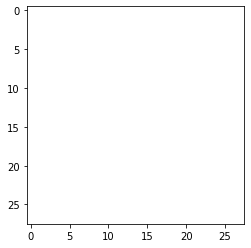

In [69]:
label = 0

targets = np.zeros(outputnodes) + 0.01
targets[label] = 0.99
plt.imshow(n.backquery(targets).reshape(28, 28), cmap='gray_r')

